In [ ]:
!pip install pytorch-complex
import torchcomplex
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from google.colab import drive

     |████████████████████████████████| 51kB 3.0MB/s 


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
!nvidia-smi

Sun Jun 20 10:27:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_data = pickle.load(open('/content/drive/My Drive/trainingData.pickle', 'rb'))

In [ ]:
Xt = []
yt = []
features = None
labels = None
label = []

In [ ]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

In [ ]:
a = np.array(Xt)
b = np.array(yt)
type(a)

numpy.ndarray

In [ ]:
# 70 % training, 15% validating, 15% testing
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.30, shuffle=True)  # 70% training, 30% testing
#X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  # split testing set into 50% validation , 50% testing

In [ ]:
print("Xtrain data shape",X_train.shape)
print("YTrain data shape",y_train.shape)

Xtrain data shape (2144, 512, 512, 3)
YTrain data shape (2144,)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd3ea8f6b90>,
 <matplotlib.image.AxesImage at 0x7fd3ea83e2d0>)

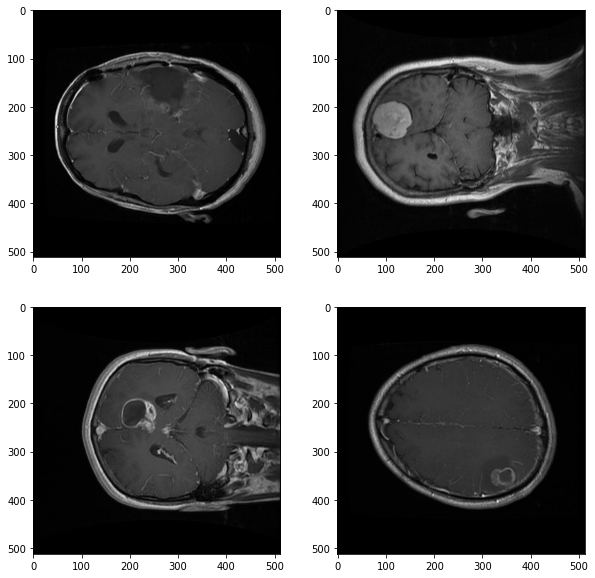

In [ ]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X_train[i], cmap='gray')
plt.subplot(222), plt.imshow(X_train[i+30], cmap='gray')
plt.subplot(223), plt.imshow(X_train[i+50], cmap='gray')
plt.subplot(224), plt.imshow(X_train[i+100], cmap='gray')

In [ ]:
X_train[1].shape

(512, 512, 3)

In [ ]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    #self.trans = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    self.tran = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # numpy array as a tensor
    #tensor = transforms.Tensor(self.X[idx])
    #tensor in complex representation
    #data = torch.fft.ifft(tensor)
    data = self.tran(self.X[idx])
    
    # store the transformed images in a list
    new_batch = [data]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0
    #labels = self.y[idx]
    new_labels = [labels]
    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

In [ ]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None
a = None
b = None

In [ ]:
train_set = BrainTumorDataset(X_train, y_train)
#valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

In [ ]:
print(f"Number of training samples: {len(X_train)}")
#print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2144
Number of testing samples: 920


In [ ]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
#valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_gen = DataLoader(test_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,64,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 16, 5)
        self.fc1 = nn.Linear(16 * 125 * 125, 1000)
        

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 125 * 125)            # -> n, 400
        #x = F.relu(self.fc1(x))               # -> n, 120
        #x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc1(x)                       # -> n, 10
        return x

In [ ]:
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# defining the model
model = ConvNet().to(device)    
print(model)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250000, out_features=1000, bias=True)
)


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 50
#epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # forward pass image sample
        y_pred = model(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(len(train_set)):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(len(test_set)):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Batch 2144
Accuracy: 70.20 %  Loss: 0.1916  Duration: 0.80 minutes
Validation Accuracy 81.20 Validation Loss: 0.2404

Epoch 2 Batch 2144
Accuracy: 84.47 %  Loss: 0.0599  Duration: 0.80 minutes
Validation Accuracy 84.35 Validation Loss: 0.1520

Epoch 3 Batch 2144
Accuracy: 89.32 %  Loss: 0.0705  Duration: 0.79 minutes
Validation Accuracy 81.74 Validation Loss: 0.1093

Epoch 4 Batch 2144
Accuracy: 91.88 %  Loss: 0.0481  Duration: 0.80 minutes
Validation Accuracy 82.83 Validation Loss: 0.0844

Epoch 5 Batch 2144
Accuracy: 95.71 %  Loss: 0.0493  Duration: 0.80 minutes
Validation Accuracy 81.52 Validation Loss: 0.0241

Epoch 6 Batch 2144
Accuracy: 96.78 %  Loss: 0.0025  Duration: 0.79 minutes
Validation Accuracy 82.17 Validation Loss: 0.2799

Epoch 7 Batch 2144
Accuracy: 98.27 %  Loss: 0.0001  Duration: 0.80 minutes
Validation Accuracy 84.46 Validation Loss: 0.0625

Epoch 8 Batch 2144
Accuracy: 98.65 %  Loss: 0.0000  Duration: 0.79 minutes
Validation Accuracy 84.35 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/bt_customCnn_model.pt')

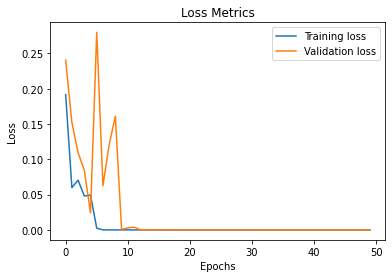

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

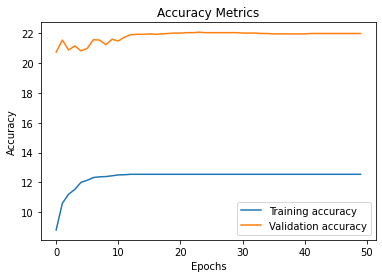

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
!pip install complexPyTorch
from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

Custom CNN

In [ ]:
class CnnNet(nn.Module):
    
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(3,64,5)
        self.bn  = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 16, 5)
        self.fc1 = nn.Linear(16*125*125, 1000)
        self.fc2 = nn.Linear(1000, 100)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,16*125*125)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# defining the model
cmodel = CnnNet().to(device)  
print(cmodel)

CnnNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
)


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(cmodel.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 10
#epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # forward pass image sample
        y_pred = cmodel(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(1*1*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = cmodel(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(1*1*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': cmodel.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 62.81 %  Loss: 5.2620  Duration: 1.43 minutes
Validation Accuracy 71.93 Validation Loss: 0.0460

Epoch 2 Batch 2144
Accuracy: 82.50 %  Loss: 0.8347  Duration: 1.43 minutes
Validation Accuracy 75.95 Validation Loss: 0.0001

Epoch 3 Batch 2144
Accuracy: 91.32 %  Loss: 0.0004  Duration: 1.43 minutes
Validation Accuracy 79.65 Validation Loss: 0.0000

Epoch 4 Batch 2144
Accuracy: 94.87 %  Loss: 0.0001  Duration: 1.43 minutes
Validation Accuracy 84.00 Validation Loss: 0.0000

Epoch 5 Batch 2144
Accuracy: 97.95 %  Loss: 0.0003  Duration: 1.43 minutes
Validation Accuracy 86.18 Validation Loss: 0.0000

Epoch 6 Batch 2144
Accuracy: 97.90 %  Loss: 0.0000  Duration: 1.43 minutes
Validation Accuracy 86.29 Validation Loss: 0.0000

Epoch 7 Batch 2144
Accuracy: 98.46 %  Loss: 0.0013  Duration: 1.43 minutes
Validation Accuracy 86.51 Validation Loss: 0.0000

Epoch 8 Batch 2144
Accuracy: 99.58 %  Loss: 0.0048  Duration: 1.43 minutes
Validation Accuracy 87.27 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


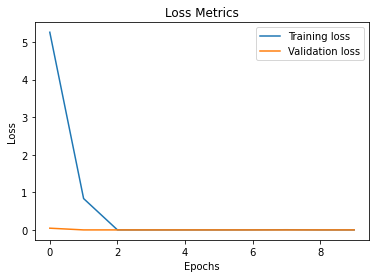

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

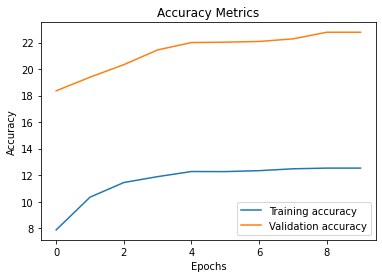

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Complex CNN

In [ ]:
class ComplexCnn(nn.Module):
    
    def __init__(self):
        super(ComplexCnn, self).__init__()
        self.conv1 = ComplexConv2d(3,64,5)
        self.bn  = ComplexBatchNorm2d(64)
        self.conv2 = ComplexConv2d(64, 16, 5)
        self.fc1 = ComplexLinear(16*125*125, 1000)
        self.fc2 = ComplexLinear(1000, 100)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,16*125*125)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# defining the model
complexdmodel = ComplexCnn().to(device)  
print(complexdmodel)

ComplexCnn(
  (conv1): ComplexConv2d(
    (conv_r): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv_i): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (bn): ComplexBatchNorm2d()
  (conv2): ComplexConv2d(
    (conv_r): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_i): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc1): ComplexLinear(
    (fc_r): Linear(in_features=250000, out_features=1000, bias=True)
    (fc_i): Linear(in_features=250000, out_features=1000, bias=True)
  )
  (fc2): ComplexLinear(
    (fc_r): Linear(in_features=1000, out_features=100, bias=True)
    (fc_i): Linear(in_features=1000, out_features=100, bias=True)
  )
)


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(complexdmodel.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 10
#epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device).type(torch.complex64), y.to(device)
        # forward pass image sample
        y_pred = complexdmodel(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(1*1*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device).type(torch.complex64), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = complexdmodel(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(1*1*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': complexdmodel.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 0.93 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 2 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 3 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 4 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 5 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 6 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 7 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 8 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration: 5.51 minutes
Validation Accuracy 0.00 Validation Loss: nan

Epoch 9 Batch 2144
Accuracy: 0.00 %  Loss: nan  Duration

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


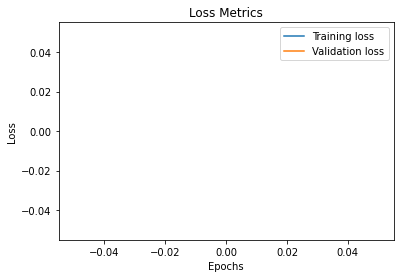

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

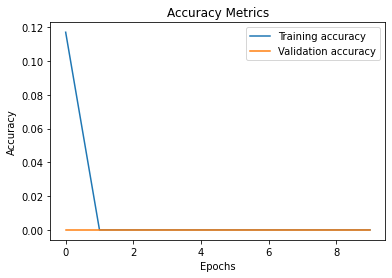

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

ResNet18

In [ ]:
resnet  = models.resnet18(pretrained=True)

# set model to run on GPU or CPU absed on availibility
resnet.to(device)

# print the trasnfer learning NN model's architecture
resnet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 10
#epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # forward pass image sample
        y_pred = resnet(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(1*1*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = resnet(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(1*1*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': resnet.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 73.54 %  Loss: 0.9389  Duration: 0.58 minutes
Validation Accuracy 77.37 Validation Loss: 0.0948

Epoch 2 Batch 2144
Accuracy: 87.63 %  Loss: 0.4640  Duration: 0.55 minutes
Validation Accuracy 81.07 Validation Loss: 0.0410

Epoch 3 Batch 2144
Accuracy: 91.13 %  Loss: 0.3089  Duration: 0.55 minutes
Validation Accuracy 83.24 Validation Loss: 0.0412

Epoch 4 Batch 2144
Accuracy: 95.05 %  Loss: 0.0460  Duration: 0.55 minutes
Validation Accuracy 91.62 Validation Loss: 0.0123

Epoch 5 Batch 2144
Accuracy: 98.23 %  Loss: 0.0081  Duration: 0.57 minutes
Validation Accuracy 95.10 Validation Loss: 0.0045

Epoch 6 Batch 2144
Accuracy: 99.11 %  Loss: 0.0030  Duration: 0.55 minutes
Validation Accuracy 95.54 Validation Loss: 0.0024

Epoch 7 Batch 2144
Accuracy: 99.95 %  Loss: 0.0024  Duration: 0.55 minutes
Validation Accuracy 96.41 Validation Loss: 0.0025

Epoch 8 Batch 2144
Accuracy: 99.95 %  Loss: 0.0015  Duration: 0.57 minutes
Validation Accuracy 96.30 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


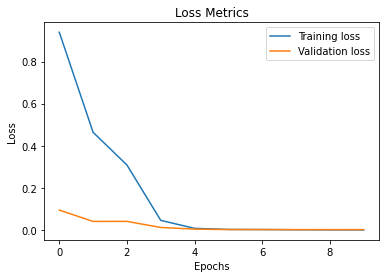

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

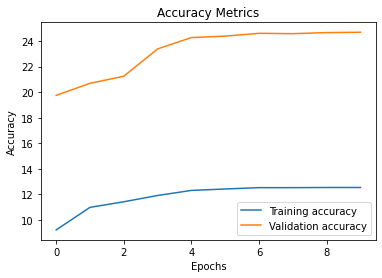

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()